In [43]:
import matplotlib.pyplot as plt
import pandas as pd
import typing as t
import collections as c

from pathlib import Path
from plot_style import *

datadirs = [
    # Path("../results_round_2/"),
    # Path("../results_round_3/"),
    Path("../results_sync_round_3/"),
]
outdir = Path("out")

model_code_to_str = {
    0: "DebugNet",
    1: "KyleNet",
    18: "ResNet-18",
    50: "ResNet-50",
    152: "ResNet-152",
}

model_order = ["DebugNet", "KyleNet", "ResNet-18", "ResNet-50", "ResNet-152"]
model_order_2 = ["TinyNet", "SmallNet", "ResNet-18", "ResNet-50", "ResNet-152"]

# Step 1: Data Parsing

In [44]:
def filter_results(datadir: Path | t.Iterable[Path]) -> t.Iterator[Path]:
    if not isinstance(datadir, c.abc.Iterable):
        datadir = [datadir]
    mask = "❯ Finished in"
    for d in datadir:
        for file in d.glob("*.stdout"):
            with open(file, "r") as f:
                text = f.read()
                if mask in text:
                    yield file

In [45]:
for f in filter_results(datadirs):
    print(f)

../results_sync_round_3/sync_50.16.stdout
../results_sync_round_3/sync_50.32.stdout
../results_sync_round_3/sync_0.16.stdout
../results_sync_round_3/sync_1.512.stdout
../results_sync_round_3/sync_0.2048.stdout
../results_sync_round_3/sync_1.2.stdout
../results_sync_round_3/sync_0.2.stdout
../results_sync_round_3/sync_0.1024.stdout
../results_sync_round_3/sync_0.256.stdout
../results_sync_round_3/sync_1.32.stdout
../results_sync_round_3/sync_152.16.stdout
../results_sync_round_3/sync_152.32.stdout
../results_sync_round_3/sync_18.16.stdout
../results_sync_round_3/sync_0.8.stdout
../results_sync_round_3/sync_1.8.stdout
../results_sync_round_3/sync_18.32.stdout
../results_sync_round_3/sync_0.4.stdout
../results_sync_round_3/sync_0.512.stdout
../results_sync_round_3/sync_152.8.stdout
../results_sync_round_3/sync_152.4.stdout
../results_sync_round_3/sync_1.2048.stdout
../results_sync_round_3/sync_18.128.stdout
../results_sync_round_3/sync_50.64.stdout
../results_sync_round_3/sync_50.4.stdout

In [46]:
def parse_file_to_record(file: Path) -> dict[str, float]:
    record = {}
    
    # Infer the experiment setup from the filename.
    stem = file.stem
    stem = stem.split("_")[-1]
    model_num, num_workers = stem.split(".")
    model_num, num_workers = int(model_num), int(num_workers)
    record["model"] = model_code_to_str[model_num]
    record["num_workers"] = num_workers
    
    # Extract the results from the stdout data.
    with open(file, "r") as f:
        for line in f.readlines():
            if line.startswith("start:"):
                value = line.split(":")[-1]
                value = float(value)
                record["start"] = value
            
            # elif line.startswith("dfk_start_done:"):
            #     value = line.split(":")[-1]
            #     value = float(value)
            #     record["dfk_start_done"] = value
            
            elif line.startswith("priming_done:"):
                value = line.split(":")[-1]
                value = float(value)
                record["priming_done"] = value
                
            elif line.startswith("end:"):
                value = line.split(":")[-1]
                value = float(value)
                record["end"] = value
    
    return record

def parse_files_to_df(datadirs: Path | t.Iterable[Path]) -> pd.DataFrame:
    if not isinstance(datadirs, c.abc.Iterable):
        datadirs = [datadirs]
        
    records: list[dict[str, float]] = [
        parse_file_to_record(file)
        for d in datadirs
        for file in filter_results(d)
    ]
    df = pd.DataFrame.from_records(records)
    df["start2end"] = df.end - df.start
    # df["dfk2end"] = df.end - df.dfk_start_done 
    df["prime2end"] = df.end - df.priming_done
    return df

In [47]:
df = parse_files_to_df(datadirs)
df.head()

,model,num_workers,start,priming_done,end,start2end,prime2end
0,ResNet-50,16,2.200140e+05,2.201235e+05,2.201537e+05,139.757655,30.241880
1,ResNet-50,32,2.201577e+05,2.202770e+05,2.203461e+05,188.416610,69.040634
2,DebugNet,16,2.140302e+05,2.140502e+05,2.140528e+05,22.563938,2.580433
3,KyleNet,512,9.088571e+06,9.088683e+06,9.088704e+06,133.311446,21.121526
4,DebugNet,2048,4.232896e+06,4.233076e+06,4.233109e+06,212.188808,32.644537


# Step 2: Data Visualization

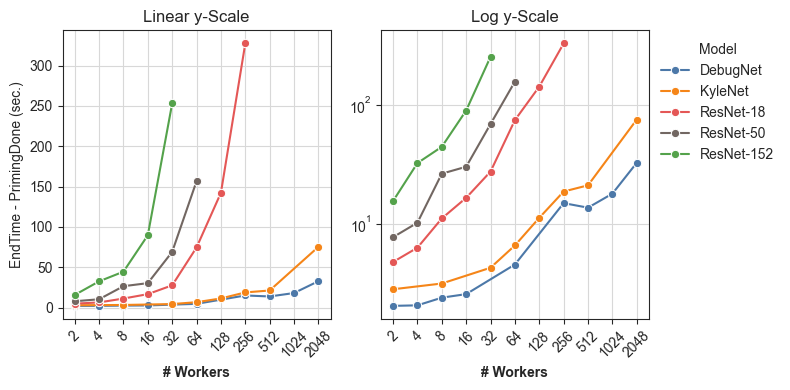

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
sns.lineplot(
    df,
    x="num_workers",
    y="prime2end",
    hue="model",
    hue_order=model_order,
    marker="o",
    ax=ax[0],
).set(yscale="linear", xscale="log")

sns.lineplot(
    df,
    x="num_workers",
    y="prime2end",
    hue="model",
    hue_order=model_order,
    marker="o",
    ax=ax[1],
).set(yscale="log", xscale="log")

ax[0].get_legend().remove()
ax[1].legend(bbox_to_anchor=(1, 1), title="Model", frameon=False)

ax[0].set_ylabel("EndTime - PrimingDone (sec.)")
ax[1].set_ylabel("")

ax[0].set_xlabel("# Workers", weight="bold")
ax[1].set_xlabel("# Workers", weight="bold")

ax[0].set_title("Linear y-Scale")
ax[1].set_title("Log y-Scale")

# ticks = [2, 16, 128, 1024]
ticks = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]
ax[0].set_xticks(ticks, ticks, rotation=45)
ax[1].set_xticks(ticks, ticks, rotation=45)

plt.tight_layout()
ax[0].minorticks_off()
ax[1].minorticks_off()
plt.savefig(outdir / "end_prime.pdf", bbox_inches="tight")
plt.show()

In [49]:
df.query("model == 'KyleNet' and num_workers == 128")

,model,num_workers,start,priming_done,end,start2end,prime2end
35,KyleNet,128,218427.431389,218464.892449,218476.163705,48.732316,11.271256


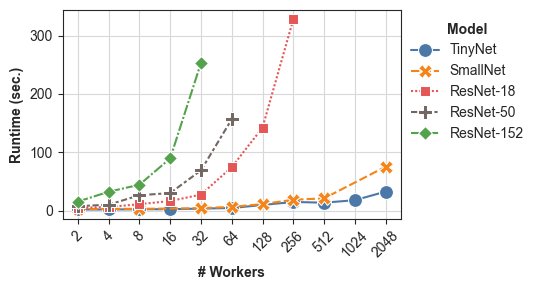

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
tmp = df.replace({"KyleNet": "SmallNet", "DebugNet": "TinyNet"})
sns.lineplot(
    tmp,
    x="num_workers",
    y="prime2end",
    hue="model",
    style="model",
    hue_order=model_order_2,
    style_order=model_order_2,
    markers=True,
    markersize=10,
    ax=ax
).set(yscale="linear", xscale="log")

# ticks = [2, 16, 128, 1024]
ticks = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]
ax.set_xticks(ticks, ticks, rotation=45)
ax.set_ylabel("Runtime (sec.)", weight="bold")
ax.set_xlabel("# Workers", weight="bold")
ax.minorticks_off()

legend = plt.legend(bbox_to_anchor=(1.4, 1), title="Model", frameon=False)
plt.setp(legend.get_title(), weight="bold")
plt.tight_layout()
plt.savefig(outdir / "end_prime_single.pdf", bbox_inches="tight")
plt.show()

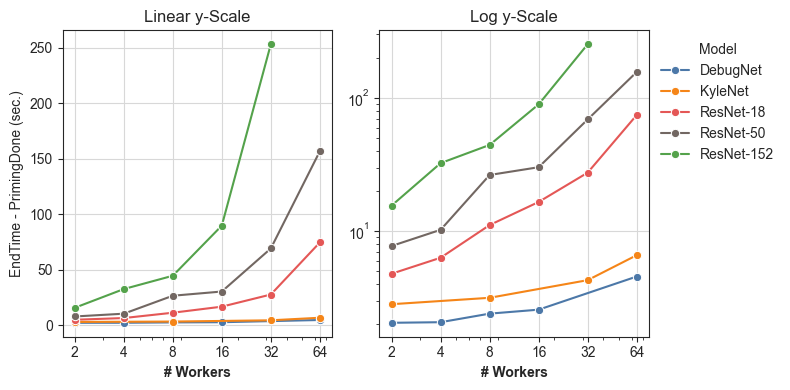

In [51]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
sns.lineplot(
    df.query("num_workers < 128"),
    x="num_workers",
    y="prime2end",
    hue="model",
    hue_order=model_order,
    marker="o",
    ax=ax[0],
).set(yscale="linear", xscale="log")

sns.lineplot(
    df.query("num_workers < 128"),
    x="num_workers",
    y="prime2end",
    hue="model",
    hue_order=model_order,
    marker="o",
    ax=ax[1],
).set(yscale="log", xscale="log")

ax[0].get_legend().remove()
ax[1].legend(bbox_to_anchor=(1, 1), title="Model", frameon=False)

ax[0].set_ylabel("EndTime - PrimingDone (sec.)")
ax[1].set_ylabel("")

ax[0].set_xlabel("# Workers", weight="bold")
ax[1].set_xlabel("# Workers", weight="bold")

ax[0].set_title("Linear y-Scale")
ax[1].set_title("Log y-Scale")

ticks = [2, 4, 8, 16, 32, 64]
ax[0].set_xticks(ticks, ticks)
ax[1].set_xticks(ticks, ticks)

plt.tight_layout()
plt.savefig(outdir / "end_prime__zoomed_in.pdf", bbox_inches="tight")
plt.show()

In [52]:
df.model.unique()

array(['ResNet-50', 'DebugNet', 'KyleNet', 'ResNet-152', 'ResNet-18'],
      dtype=object)